In [1]:
from collections import defaultdict #allows access to undefined keys, i.e. keys that have no value
import matplotlib.pyplot as plt #drawing plots 
from matplotlib.patches import Patch #draw shapes
import numpy as np #data and array manipulation
import seaborn as sns #data visualization
from tqdm import tqdm #progress bar
import gymnasium as gym

In [2]:
env = gym.make('Blackjack-v1', sab = True, render_mode = 'rgb_array')

Observing the environment

In [3]:
#reset the environment to get the first observation
done = False
observation, info = env.reset()

#observation = (16, 9, False) => (Player's current sum, Dealer's face-up card, Usable Ace with value of 11)

EXTRA INFO:

1) env.step(action): one step to interact with environment; one turn in game
2) next_state: observation tha model/agent receives after taking the action
3) reward: feedback that agent receives after taking the action; determined by next_state
4) terminated: boolean that indicates whether or not the environment has ended
5) truncated: boolean that indicates whether the episode ended by truncation; time limit reached, or other
6) info: dictionary/map that contains additional info about environment

In [4]:
#samples a random action from all valid actions

action = env.action_space.sample()
#action = 1

#execute the action in our environment and receive info after taking the step
observation, reward, terminated, truncated, info = env.step(action)

#observation = (24,10,False)
#reward = -1.0; losing a step
#terminated = True
#truncated = False
#info = {}

if terminated == True, we should stop the current episode and begin a new instance of the environment via env.reset()

Epsilon-Greedy strategy to solve Blackjack

1) in this strategy, the agent takes an action that is either the best action based on the current policy (w/ probability of 1 - epsilon) or a random action (w/ probability of epsilon).
this approach balances the exploitation of the current best policy with exploration of new policies.

2) In blackjack, epsilon-greedy can be applied to determine whether the player should hit or stand. At each step of the game, the agent/player can choose to take the action that is either recommended by the current policy, or a random action. The policy is learned over time by updating the action-value estimates of each state-action pair based on the rewards received during the game.

3) as the game is played repeatedly, the agent learns the opitmal policy that maximizes the expected reward. Initially, the agent may explore by taking random actions to discover new strategies. However, as the game progresses, the the agent will start to exploit the best-known policy, which should maximize the expected reward over time.

The epsilon value decays over time to ensure that the current strategy is used more frequently.

In [5]:
class BlackjackAgent:
    def __init__(self, learning_rate:float, initial_epsilon:float, epsilon_decay:float, final_epsilon:float, discount_factor:float = 0.95):
        # Initialize RL agent with empty dictionary of state-action values (q_values), a learning rate, and an epsilon
        # Q-table represents the expected reward for each action in each state, and based on this reward, the policy is what determines the actions to be taken in each possible state
        # Q-table stores states (the environment that the agent may currently be in), the actions possible in this current environment, and the expected future reward of each action
        # Q-values can be used to estimate the optimal actions to take in each state; It is the one that maximizes the long-term reward
        # discount_factor: the discount factor for computing the Q-value
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))
        self.lr = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.training_error = []

    def get_action(self, observation:tuple[int, int, bool]) -> int:
        # returns the best action with probability (1 - epsilon), otherwise a random action with probability (epsilon) to ensure exploration
        if np.random.rand() < self.epsilon:
            return env.action_space.sample()
        else:
            return int(np.argmax(self.q_values[observation]))
        
    def update(self, observation:tuple[int, int, bool], action:int, reward:float, terminated:bool, next_obs:tuple[int, int, bool]):
        # updates the Q-values of actions
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[observation][action]
        )
        self.q_values[observation][action] = (
            self.q_values[observation][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        # decays epsilon towards the final epsilon value at the rate defined by epsilon_decay
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)
    



In [6]:
# Hyper Parameters
learning_rate = 0.01
n_episodes = 100000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) #reduce the exploration over time
final_epsilon = 0.1
# ------------------

agent = BlackjackAgent(
    learning_rate = learning_rate,
    initial_epsilon = start_epsilon,
    epsilon_decay = epsilon_decay,
    final_epsilon = final_epsilon,
    #discount_factor has a default value of 0.95, so we don't need to declare its value here
)

In [7]:
pbar = tqdm(range(n_episodes))

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size = n_episodes)
for episode in pbar:
    observation, info = env.reset()
    done = False

    #play one episode
    while not done:
        action = agent.get_action(observation)
        next_obs, reward, terminated, truncated, info = env.step(action)

        agent.update(observation, action, reward, terminated, next_obs)

        done = terminated or truncated
        observation = next_obs
    
    agent.decay_epsilon()

    if episode % 1000 == 0:
        pbar.set_description(f'Episode {episode} | Epsilon: {agent.epsilon:.4f}')

print("Training completed")
    

  0%|          | 0/100000 [00:00<?, ?it/s]

Episode 99000 | Epsilon: 0.1000: 100%|██████████| 100000/100000 [00:27<00:00, 3678.89it/s]

Training completed


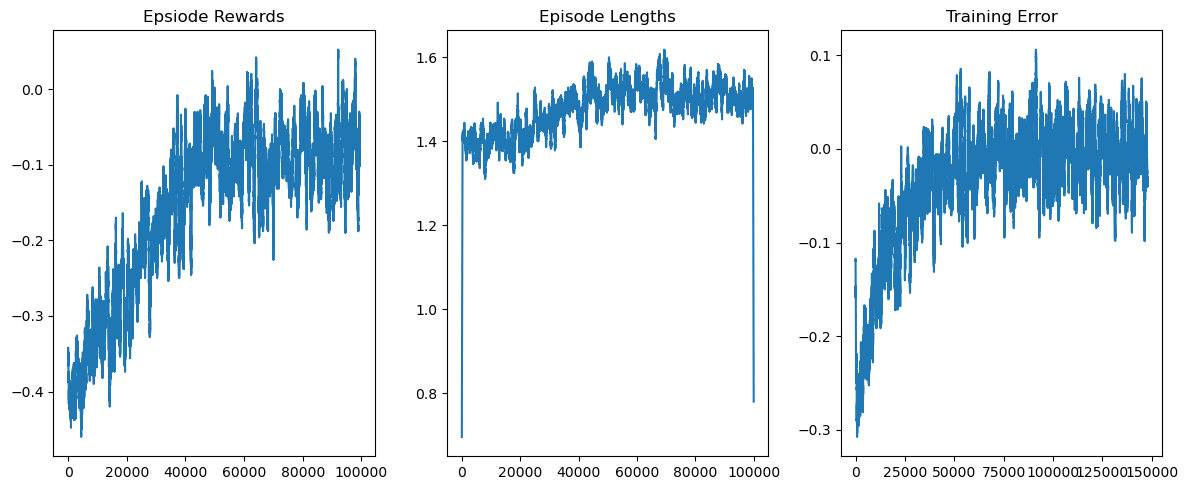

In [8]:
rolling_length = 500
fig, axis = plt.subplots(ncols = 3, figsize = (12, 5))
axis[0].set_title('Epsiode Rewards')
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode = 'valid'
    ) / rolling_length
)
axis[0].plot(range(len(reward_moving_average)), reward_moving_average)
axis[1].set_title('Episode Lengths')
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode = 'same'
    ) / rolling_length
)
axis[1].plot(range(len(length_moving_average)), length_moving_average)
axis[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axis[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()